# Spark 클러스터 구축(HDFS, YARN) 실습

* 구축한 Hadoop 클러스터를 기반으로 파일 시스템은 HDFS, 클러스터 매니저는 YARN을 사용하는 Spark클러스터 구축
* 각 서버(가상머신)별 구축 현황은 다음과 같다.

|호스트명|설치내용|Processors|Memory|Storage|OS|
|---|---|---|---|---|---|
|master|[HDFS] NameNode<br> [YARN] ResourceManager<br> [MapReduce] Job History Server<br> [Spark] Master HistoryServer|2|4GB|20GB|Ubuntu 20.04|
|worker01|[HDFS] SecondaryNameNode<br> DataNode<br> [YARN] NodeManager<br> [Spark] Worker|2|4GB|20GB|Ubuntu 20.04|
|worker02|[HDFS] DataNode<br> [YARN] NodeManager<br> [Spark] Worker|2|2GB|20GB|Ubuntu 20.04|
|worker03|[HDFS] DtataNode<br> [YARN] NodeManager<br> [Spark] Worker|2|2GB|20GB|Ubuntu 20.04|

### Hadoop 구동 확인

In [ ]:
# [master]에서 다음의 명령어 실행
# 만약 namenode가 보이지 않는다면 실행
$HADOOP_HOME/bin/hdfs namenode -format
$HADOOP_HOME/bin/hdfs --daemon start namenode

# 모두 실행
$HADOOP_HOME/sbin/start-all.sh
$HADOOP_HOME/bin/mapred --daemon start historyserver

# jps로 구동확인
# 보다 원활한 진행을 위해 worker01까지만 확인
jps

* master

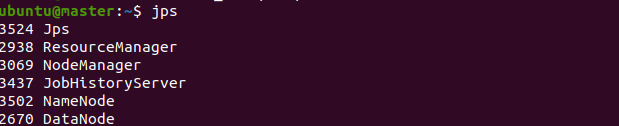

* worker01

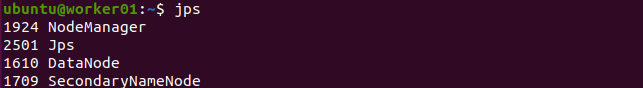

### NameNode가 나타나지 않을 경우

- (마스터) Workers 파일에 Master 넣은 것 빼고, Worker01만 기재

- stop-all.sh  20초 대기

- (모두) sudo rm -r /usr/local/hadoop/data
 
- (모두) sudo rm -r /usr/local/hadoop/pids

- (마스터) $HADOOP_HOME/bin/hdfs namenode -format 20초 대기

- start-all.sh (또는 개별적으로 실행)

## 1. Spark 설정 및 클러스터 구축

* master에서 Spark설정 완료 후 다른 서버로 복사

### spark-env.sh 파일 수정
* spark-env.sh 파일은 Spark의 환경설정을 위한 스크립트 파일로 Spark 클러스터의 모든 노드에 적용

* spark-env.shtemplate파일을 복사하여 spark-env.sh파일을 생성 한 후 파일 열기

In [ ]:
# template 파일 복사 루 파일 열기
sudo cp $SPARK_HOME/conf/spark-env.sh.template $SPARK_HOME/conf/spark-env.sh

# vi를 사용하여 파일 열기
sudo vi $SPARK_HOME/conf/spark-env.sh

In [ ]:
# 환경변수 설정
export JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64
export SPARK_MASTER_HOST=master
export HADOOP_CONF_DIR=/usr/local/hadoop/etc/hadoop

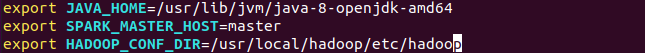

#### JAVA_HOME
- Spark는 JVM을 사용하므로 Java 설치 경로 지정
- 이미 시스템 및 사용자 환경변수에 저장되어 있지만, 서로 다른 환경의 서버들에 일관성 확보를 위하여 설정 파일에 명시
#### SPARK_MASTER_HOST
- Spark MasterNode가 바인딩할 호스트나 IP주소 설정
- WorkerNode가 네트워크에서 MasterNode를 찾는데 사용
#### SPARK_MASTER_PORT
- Spark MasterNode가 바인딩할 포트
- 기본값; 7077
#### HADOOP_CONF_DIR
- Hadoop설정 파일(core-site.xml, hdfs-site.xml, yarn-site.xml, ...)이 포함된 디렉토리 경로 설정
- Spark는 HDFS에서 데이터를 읽고 쓰기 위해 Hadoop과 통신하므로, 이 환경변수가 올바르게 설정되어 있어야 한다.
#### YARN_CONF_DIR
- YARN 설정 파일(yarn-site.xml)이 포함된 디렉토리
- 보통 HADOOP_CONF_DIR과 같은 경로이므로 HADOOP_CONF_DIR가 설정되어 있는 경우, Spark는 이를 참조하여 YARN설정을 찾으려 시도
- HADOOP_COM_DIR와 YARN_CONF_DIR의 경로가 다르다면 반드시 설정 필요

### spark-defaults.conf 파일 수정
* spark-defaults.conf는 Spark Application을 실행할 때 적용되는 기본 속성들을 정의한 파일
* 모든 Spark Application에 적용되며, 각 Spark Application은 이 기본 설정을 오버라이드 가능
* Standalone, YARN, Mesos등 다양한 클러스터 매니저와 함께 사용 가능한 설정 제공

* spark-defaults.conf.template파일을 복사하여 spark-defaults.conf 파일을 생성한 후 열기

In [ ]:
# template파일을 복사, spark-defaults.conf 파일을 생성
sudo cp $SPARK_HOME/conf/spark-defaults.conf.template $SPARK_HOME/conf/spark-defaults.conf

# 파일 열기
sudo vi $SPARK_HOME/conf/spark-defaults.conf

In [ ]:
# 속성 설정
spark.master yarn
spark.eventLog.enabled true
spark.eventLog.dir hdfs://master:9000/user/ubuntu/spark-logs
spark.hisotry.fs.logDirectory hdfs://master:9000/user/ubuntu/spark-logs

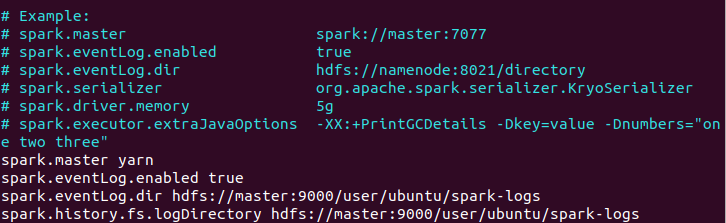

#### spark.master
- Spark Application을 실행하는 클러스터매니저 설정
- local: 로컬모드로 실행
- local[N]: 로컬모드로 실행, N개의 스레드 사용
- local[*]: 로컬모드로 실행되며, 사용가능한 모든 코어 사용
- spark://<host>:<port>: Spark의 standalone 클러스터 매니저 사용
- yarn: YARN을 클러스터 매니저로 사용
- mesos://<host>:<port>: Mesos를 클러스터 매니저로 사용
- k8s://https://<api_server_host>:<api_server_port>: Kubernetes를 클러스터 매니저로 사용
    
#### spark.eventLog.enabled
- Spark의 작업에 대한 이벤트 로깅 활성화 여부를 설정
- true: Spark작업의 모든 이벤트 정보를 로그 파일에 기록, 이벤트 로그를 통해 작업의 성공, 실패, 프로그래스 증을 추적할 수 있으며, 웹 UI에서 작업의 세부 정보를 볼 수 있음
- false: 기본값
- true일 경우 추가적인 디스크 I/O 부하가 발생할 수 있음
- 이 설정을 true로 변경하면, spark.enentlog.dir 설정을 통해 이벤트 로그가 저장될 경로를 지정해야 한다.

#### spark.eventLog.dir
- Spark의 이벤트 로그를 저장할 경로 설정
- HDFS에 이벤트 로그를 저장할경우 다음과 같은 이점 존재
    - **내구성**: HDFS는 저장 파일을 복제하므로 한 노드에서 장애가 일어나더라도 로그 데이터가 유실되지 않음(로컬 파일 시스템은 로그 데이터가 저장된 노드에 장애가 일어나면 데이터 유실)
    - **확장성**: HDFS는 클러스터 전체의 디스크 공간을 활용하므로 대용량의 데이터 저장 가능
    - **접근성**: 클러스터 각 노드에서 생성되는 로그를 중앙 집중식으로 저장하고 관리할 수 있어 분석 용이
    - **Spark History Server와의 호환성**: Spark History Server는 spark.eventLog.dir에서 로그 파일을 읽어와 작업 이력을 시각화하는데, HDFS에 이 로그를 저장하면 Spark History Server가 클러스터 전체에 엑세스 가능
 
* hadoop.NameNode의 포트는 core-site.xml의 fs.defaults에 설정한 포트 사용
* spark.eventLog.dir에 명시된 경로는 미리 생성되어 있어야 하며 Spark Application 실행자가 HDFS상의 해당 경로를 수정할 수 있는 권한이 있어야 한다.
    
#### spark.history.fs.logDirectory
* Spark History Server가 Spark Application의 이벤트로그를 읽어오는 경로 설정
* 일반적으로 spark.eventLog.dir와 같은 값 설정

In [ ]:
# spark-defults.conf에 작성했던 디렉토리 생성해주기
# hdfs를 실행 시에 sudo로 실행한 경우 디렉토리 생성 시에 마찬가지로 sudo를 붙여줘야 한다
sudo $HADOOP_HOME/bin/hadoop fs -mkdir /user
sudo $HADOOP_HOME/bin/hadoop fs -mkdir /user/ubuntu
sudo $HADOOP_HOME/bin/hadoop fs -mkdir /user/ubuntu/spark-logs

# 방법2
hadoop fs -mkdir /user
hadoop fs -mkdir /user/ubuntu
hadoop fs -mkdir /user/ubuntu/spark-logs

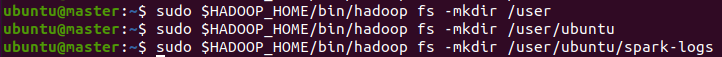

### workers 파일 수정
* conf/workers.template파일을 복사해 workers 파일을 생성하여 hadoop과 유사하게 WorkerNode호스트들을 입력

In [ ]:
sudo cp $SPARK_HOME/conf/workers.template $SPARK_HOME/conf/workers
sudo vi $SPARK_HOME/conf/workers

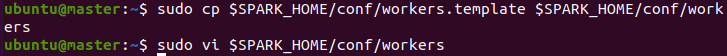

* 필요에 따라 worker의 개수를 조절해줄 수 있다.

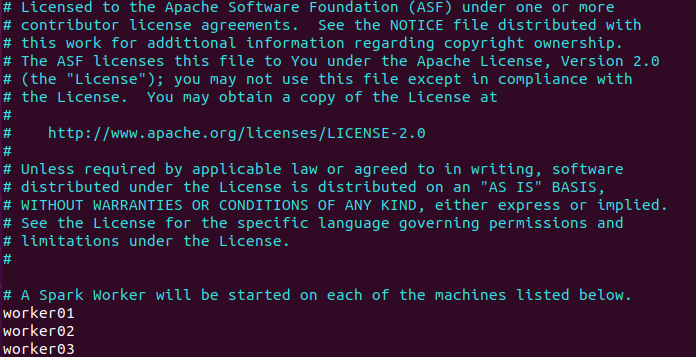

### 각 가상머신으로 파일 복사

* /usr/local로 이동하여 설정을 완료한 Spark로 압축파일 생성

In [ ]:
# 유저가 hadoop일 경우 ubuntu로 전환해준다.
su ubuntu

# 압축파일 생성
sudo tar -czf spark.tar.gz spark
sudo mv spark.tar.gz /home/ubuntu/spark.tar.gz

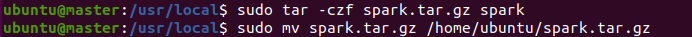

* /home/ubuntu로 이동하여 scp명령어를 사용하여 모든 WorkerNode로 Spark파일 전송

In [ ]:
# 모든 WorkerNode에 압축파일 전송
scp spark.tar.gz ubuntu@worker01:/home/ubuntu/
scp spark.tar.gz ubuntu@worker02:/home/ubuntu/
scp spark.tar.gz ubuntu@worker03:/home/ubuntu/

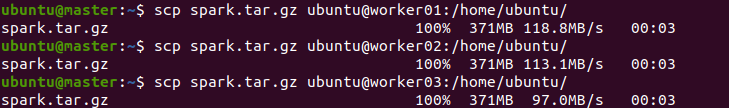

* 전송한 압축파일 풀고 기존의 압축파일 해제

In [ ]:
# 압축파일 풀기 및 해제
ssh ubuntu@worker01 "cd /home/ubuntu; tar xzf spark.tar.gz; rm spark.tar.gz"
ssh ubuntu@worker02 "cd /home/ubuntu; tar xzf spark.tar.gz; rm spark.tar.gz"
ssh ubuntu@worker03 "cd /home/ubuntu; tar xzf spark.tar.gz; rm spark.tar.gz"

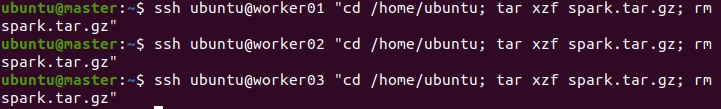

* 각 가상머신들에서 /home/ubuntu에 위치한 Spark 디렉토리를 /usr/local로 이동

In [ ]:
# [worker01, worker02, worker03]모두 실행
# 파일 이동
sudo mv spark /usr/local/spark

# 올바르게 이동되었는지 확인
cd /usr/local/spark
ls

* worker01

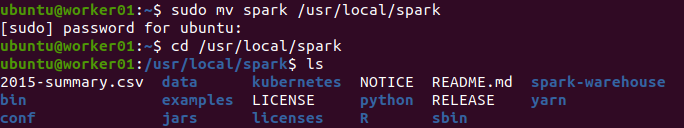

* worker02

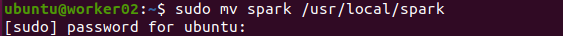

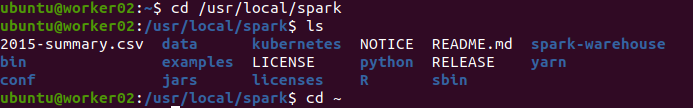

* worker03

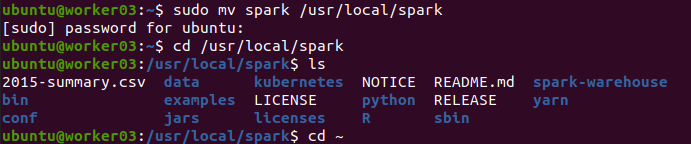

### 환경변수 설정

* 각 worker노드들에 SPARK_HOME 사용자 환경변수 설정

In [ ]:
# [worker01, worker02, worker03]모두 실행
echo 'export SPARK_HOME="/usr/local/spark"' >> ~/.bashrc
source ~/.bashrc

# 경로 확인
echo $SPARK_HOME

* worker01

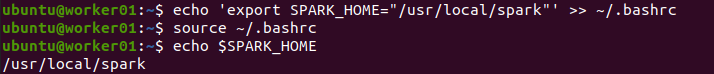

* worker02

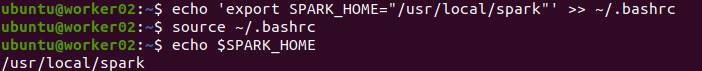

* worker03

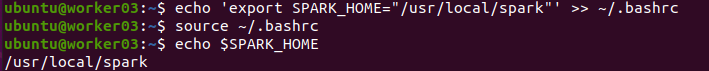

## 2. Spark 클러스터 실행 및 종료

### Spark 실행과 종료
* Hadoop과 마찬가지로 ssh에 대한 password-less 설정을 완료했으며, workers 파일에 각 노드들의 호스트명을 작성했다면 master에서 아래의 간단한 명령어를 통해 Spark 클러스터 구동 가능

In [ ]:
# 모두 실행
$SPARK_HOME/sbin/start-all.sh

# Master만 실행
$SPARK_HOME/sbin/start-master.sh

# Worker들만 실행
$SPARK_HOME/sbin/start-workers.sh

# Spark History Server 실행
$SPARK_HOME/sbin/start-history-server.sh

* Spark 실행시 로그 저장 경로가 /usr/local/spark/logs/spark-ununtu-org.apache.spark.deploy.master.Master-1-master.out와 갗이 출력되는데, 해당 경로는 해당 노드 자체에 대한 로그로 위에서 HDFS에 설정한 Spark Application 이벤트 로그와는 다름

* master: 전체 실행

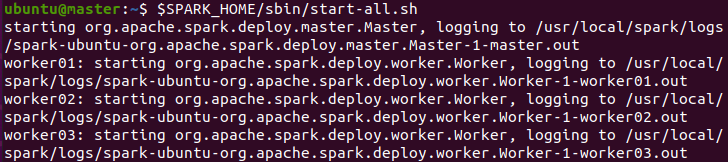

### 구동 여부 확인

In [ ]:
# 구동 여부 확인 
sudo jps

* master

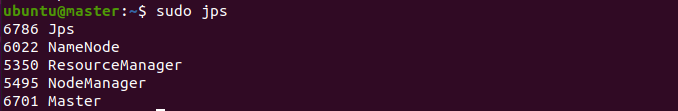

* worker01

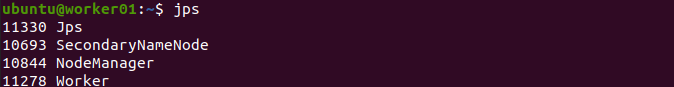

* worker02

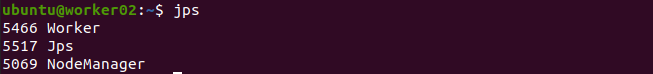

* worker03

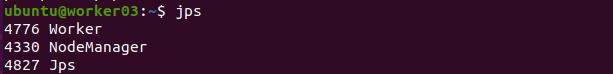

### 종료

In [ ]:
# 모두 종료
$SPARK_HOME/sbin/stop-all.sh

# Master만 종료
$SPARK_HOME/sbin/stop-master.sh

# Worker들만 종료
$SPARK_HOME/sbin/stop-workers.sh

# Spark History Server 종료
$SPARK_HOME/sbin/stop-history-server.sh

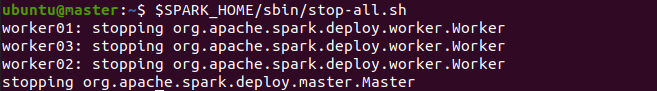